
=== Exemple 1 ===

Méthode Classique:

=== Résultats (classique) ===
[Doc 1] Score: 1.00 | Contenu: Algèbre linéaire et matrices
[Doc 4] Score: 0.50 | Contenu: Matrices et déterminants

matrice apres bidiag :
(array([[-7.07106781e-01,  0.00000000e+00,  0.00000000e+00,
        -7.07106781e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -7.07106781e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.07106781e-01,  0.00000000e+00,  0.00000000e+00,
        -7.07106781e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.22044605e-16, -1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0

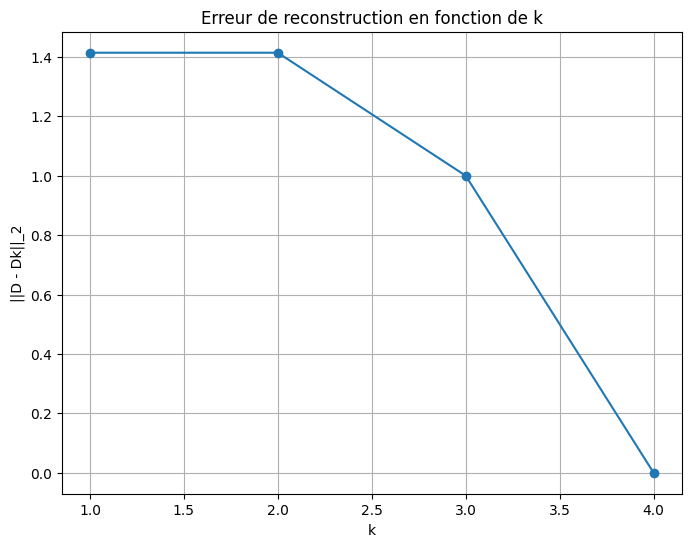


=== documents.txt ===
Requête aléatoire: apple

Méthode Classique:

=== Résultats (classique) ===
[Doc 2] Score: 0.58 | Contenu: apple banana orange

Méthode SVD:

=== Résultats (SVD) ===
[Doc 2] Score: 1.00 | Contenu: apple banana orange

Méthode Bidiag + QR:

=== Résultats (bidiag + QR) ===
[Doc 2] Score: 1.00 | Contenu: apple banana orange


In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
from numpy.linalg import svd, qr, norm
import random

# === Construction de la matrice terme-document ===
def construire_matrice(termes, docs):
    termes_norm = sorted(t.lower() for t in termes)
    docs_tokenisés = [doc.lower().split() for doc in docs]
    matrice = np.zeros((len(termes_norm), len(docs)), dtype=int)
    for i, terme in enumerate(termes_norm):
        for j, mots_doc in enumerate(docs_tokenisés):
            if terme in mots_doc:
                matrice[i, j] = 1
    return matrice, termes_norm

# === Transformation d'une requête textuelle en vecteur binaire ===
def transformer_requete(termes, requete):
    mots_requete = requete.lower().split()
    vecteur = [1 if any(fuzz.ratio(terme, mot) > 85 for mot in mots_requete) else 0 for terme in termes]
    return np.array(vecteur)

# === Calcul de similarité (produit scalaire normalisé) classique ===
def similarite_classique(matrice, vect_q):
    scores = []
    for j in range(matrice.shape[1]):
        vect_d = matrice[:, j]
        num = np.dot(vect_d, vect_q)
        den = norm(vect_d) * norm(vect_q)
        score = num / den if den != 0 else 0
        scores.append(round(score, 2))
    return scores

# === Similarité après réduction SVD (Analyse Sémantique Latente) ===
def similarite_svd(matrice, vect_q, k=5):
    U, S, VT = svd(matrice, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vk = VT[:k, :]
    q_proj = np.dot(np.dot(vect_q, Uk), np.linalg.inv(Sk))
    docs_proj = np.dot(Sk, Vk)
    scores = []
    for j in range(docs_proj.shape[1]):
        d_proj = docs_proj[:, j]
        num = np.dot(q_proj, d_proj)
        den = norm(q_proj) * norm(d_proj)
        score = num / den if den != 0 else 0
        scores.append(round(score, 2))
    return scores

# === Bidiagonalisation suivie de SVD (approche alternative) ===
def bidiagonalization(A):
    m, n = A.shape
    B = A.copy().astype(float)
    U = np.eye(m, dtype=float)
    V = np.eye(n, dtype=float)
    for k in range(min(m, n)):
        # Étape de Householder sur les colonnes
        x = B[k:, k]
        v = x.copy()
        v_norm = norm(x)
        v[0] += np.sign(x[0]) * v_norm if v_norm != 0 else 0
        v = v / norm(v) if norm(v) != 0 else v
        B[k:, k:] -= 2 * np.outer(v, np.dot(v, B[k:, k:]))
        U[k:] -= 2 * np.outer(v, np.dot(v, U[k:]))
        if k < n - 1:
            # Étape de Householder sur les lignes
            x = B[k, k+1:]
            v = x.copy()
            v_norm = norm(x)
            v[0] += np.sign(x[0]) * v_norm if v_norm != 0 else 0
            v = v / norm(v) if norm(v) != 0 else v
            B[k:, k+1:] -= 2 * np.dot(B[k:, k+1:], v).reshape(-1, 1) * v
            V[k+1:] -= 2 * np.outer(v, np.dot(v, V[k+1:]))
    return U, B, V

# === Similarité utilisant Bidiagonalisation + QR (variation de SVD) ===
def similarite_bidiag_qr(matrice, vect_q, k=5):
    U, B, V = bidiagonalization(matrice)
    Ub, S, Vb = svd(B, full_matrices=False)
    S = S[:k]
    S = np.where(S > 1e-10, S, 1e-10)
    Ub = Ub[:, :k]
    Vb = Vb[:k, :]
    Uk = np.dot(U, Ub)
    Vk = np.dot(Vb, V)
    Sk = np.diag(S)
    q_proj = np.dot(vect_q, Uk) @ np.linalg.inv(Sk)
    docs_proj = np.dot(Sk, Vk)
    scores = []
    for j in range(docs_proj.shape[1]):
        d_proj = docs_proj[:, j]
        num = np.dot(q_proj, d_proj)
        den = norm(q_proj) * norm(d_proj)
        score = num / den if den != 0 else 0
        scores.append(round(score, 2))
    return scores

# === Affichage des scores de similarité par document ===
def afficher_scores(scores, docs, méthode, seuil=0.0):
    print(f"\n=== Résultats ({méthode}) ===")
    scores_utiles = [(i, s) for i, s in enumerate(scores) if s > seuil]
    if not scores_utiles:
        print("Aucun document pertinent trouvé.")
        return
    scores_triés = sorted(scores_utiles, key=lambda x: x[1], reverse=True)
    for idx, score in scores_triés:
        print(f"[Doc {idx+1}] Score: {score:.2f} | Contenu: {docs[idx]}")

# === Calcul de l'erreur de reconstruction pour la réduction SVD ===
def reconstruction_error(matrice, k):
    U, S, VT = svd(matrice, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vk = VT[:k, :]
    Dk = np.dot(Uk, np.dot(Sk, Vk))
    return norm(matrice - Dk, ord=2)

# === Chargement d’un fichier texte ligne par ligne ===
def load_documents(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print("Fichier non trouvé.")
        return []

# === Extraction des mots-clés uniques à partir des documents ===
def extract_keywords(documents):
    words = set()
    for doc in documents:
        words.update(doc.lower().split())
    return sorted(list(words))

# === Programme principal ===
if __name__ == "__main__":
    # Exemple 1 : documents mathématiques
    documents_ex1 = [
        "Algèbre linéaire et matrices",
        "Analyse réelle et suites",
        "Probabilités et statistiques",
        "Matrices et déterminants"
    ]
    vocabulaire_ex1 = [
        "algèbre", "matrices", "analyse", "suites",
        "probabilités", "statistiques", "déterminants"
    ]
    requete_ex1 = "matrice algèbre"

    print("\n=== Exemple 1 ===")
    M_ex1, termes_ex1 = construire_matrice(vocabulaire_ex1, documents_ex1)
    vect_req_ex1 = transformer_requete(termes_ex1, requete_ex1)

    print("\nMéthode Classique:")
    afficher_scores(similarite_classique(M_ex1, vect_req_ex1), documents_ex1, "classique")
    print("\nmatrice apres bidiag :")
    print(bidiagonalization(M_ex1))
    print("\nMéthode SVD:")
    afficher_scores(similarite_svd(M_ex1, vect_req_ex1), documents_ex1, "SVD")

    print("\nMéthode Bidiag + QR:")
    afficher_scores(similarite_bidiag_qr(M_ex1, vect_req_ex1), documents_ex1, "bidiag + QR")
    

    # Exemple 3 : documents économiques
    documents_ex3 = [
        "Croissance économique et dépression",
        "Fiscalité des bassins industriels",
        "Analyse des cycles économiques",
        "Politiques fiscales et croissance"
    ]
    vocabulaire_ex3 = [
        "croissance", "dépression", "fiscalité", "bassins",
        "économiques", "cycles", "politiques"
    ]
    requetes_ex3 = ["dépression croissance", "bassin fiscalité"]

    print("\n=== Exemple 3 ===")
    M_ex3, termes_ex3 = construire_matrice(vocabulaire_ex3, documents_ex3)
    for req in requetes_ex3:
        print(f"\nRequête: {req}")
        vect_req_ex3 = transformer_requete(termes_ex3, req)

        print("\nMéthode Classique:")
        afficher_scores(similarite_classique(M_ex3, vect_req_ex3), documents_ex3, "classique", seuil=0.5)

        print("\nMéthode SVD:")
        afficher_scores(similarite_svd(M_ex3, vect_req_ex3), documents_ex3, "SVD", seuil=0.5)

        print("\nMéthode Bidiag + QR:")
        afficher_scores(similarite_bidiag_qr(M_ex3, vect_req_ex3), documents_ex3, "bidiag + QR", seuil=0.5)

    # Courbe : erreur de reconstruction selon k
    k_values = range(1, min(M_ex1.shape) + 1)
    errors = [reconstruction_error(M_ex1, k) for k in k_values]
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, errors, marker='o')
    plt.title("Erreur de reconstruction en fonction de k")
    plt.xlabel("k")
    plt.ylabel("||D - Dk||_2")
    plt.grid(True)
    plt.show()
    plt.close()

    # Courbe : temps d'exécution selon le nombre de documents
    Nd_values = list(range(5, 201, 5))
    times_classique, times_svd, times_bidiag = [], [], []

    for Nd in Nd_values:
        Ni = 3 * Nd
        D = np.random.randint(0, 2, (Ni, Nd))
        q = np.random.randint(0, 2, Ni)

        start = time.time()
        similarite_classique(D, q)
        times_classique.append(time.time() - start)

        start = time.time()
        similarite_svd(D, q, k=2)
        times_svd.append(time.time() - start)

        start = time.time()
        similarite_bidiag_qr(D, q, k=2)
        times_bidiag.append(time.time() - start)

    plt.figure(figsize=(10, 6))
    plt.plot(Nd_values, times_classique, label="Classique", marker='o')
    plt.plot(Nd_values, times_svd, label="SVD", marker='s')
    plt.plot(Nd_values, times_bidiag, label="Bidiag + QR", marker='^')
    plt.title("Temps d'exécution en fonction de Nd")
    plt.xlabel("Nd (nombre de documents)")
    plt.ylabel("Temps (secondes)")
    plt.legend()
    plt.grid(True)
    plt.savefig("execution_time.png")
    plt.close()

    # Exemple avec un fichier texte externe
    file_path = "documents.txt"
    documents = load_documents(file_path)
    if documents:
        keywords = extract_keywords(documents)
        random_query = random.choice(keywords)
        print("\n=== documents.txt ===")
        print(f"Requête aléatoire: {random_query}")
        M, termes = construire_matrice(keywords, documents)
        vect_req = transformer_requete(termes, random_query)

        print("\nMéthode Classique:")
        afficher_scores(similarite_classique(M, vect_req), documents, "classique")

        print("\nMéthode SVD:")
        afficher_scores(similarite_svd(M, vect_req), documents, "SVD")

        print("\nMéthode Bidiag + QR:")
        afficher_scores(similarite_bidiag_qr(M, vect_req), documents, "bidiag + QR")


In [10]:
B=np.array([[1,0,0,0],[0,1,1,0],[0,0,0,1]])
qb=np.array([1,0,1])
print("\n B classique\n")
print(B.shape[1])
print(similarite_classique(B, qb))


 B classique

4
[np.float64(0.71), np.float64(0.0), np.float64(0.0), np.float64(0.71)]
